<a href="https://colab.research.google.com/github/Nishu39321/AnamolyDetectionPRMLProject/blob/main/NIDS_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
# Sigmoid function with clipping to avoid overflow
def Sigmoid(Z):
    Z = np.clip(Z, -500, 500)  # Clip values to avoid overflow
    return 1 / (1 + np.exp(-Z))

# Custom Logistic Regression class
class My_Logistic_Regression():
    def __init__(self, max_iter=1000, learning_rate=0.01):
        self.max_iter = max_iter
        self.learning_rate = learning_rate

    def fit(self, X, y):
        m, n = X.shape
        y = np.array(y).reshape(-1, 1)

        # Add intercept term (bias) to X
        X = np.hstack((np.ones((m, 1)), X))

        # Initialize weights with small random values
        W = np.random.randn(n + 1, 1)

        # Gradient descent loop
        for i in range(self.max_iter):
            y_hat = Sigmoid(X @ W)

            # Compute the gradient of the loss function
            gradient = (1 / m) * X.T @ (y_hat - y)

            # Update the weights
            W -= self.learning_rate * gradient
        self.W = W
        return W[1:]  # Return weights excluding the bias term

    def predict(self, X):
        m, n = X.shape
        X = np.hstack((np.ones((m, 1)), X))  # Add intercept term (bias) to X
        y_hat = Sigmoid(X @ self.W)
        return (y_hat >= 0.3).astype(int)  # Return 0 or 1



In [5]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
# Custom sigmoid and model
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier

columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# ✅ Load your local dataset (NOT Colab path!)
df = pd.read_csv("/content/drive/MyDrive/Train_data.csv", header=None, names=columns, low_memory=False)
df = df[df["duration"] != "duration"]

# Separate features and labels
X = df[columns[:-1]].copy()
y = df["label"]

# Encode categorical variables
le_protocol = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()

X["protocol_type"] = le_protocol.fit_transform(X["protocol_type"])
X["service"] = le_service.fit_transform(X["service"])
X["flag"] = le_flag.fit_transform(X["flag"])

# Save encoders
joblib.dump(le_protocol, "le_protocol.pkl")
joblib.dump(le_service, "le_service.pkl")
joblib.dump(le_flag, "le_flag.pkl")

# Encode labels
y = y.apply(lambda x: 0 if x == "normal" else 1)

# Shuffle and split
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale and transform features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, "scaler.pkl")

poly = PolynomialFeatures(degree=1)
X_trf = poly.fit_transform(X_scaled)

# Train custom logistic regression model
model = My_Logistic_Regression(max_iter=1000)
model.fit(X_trf, y_train)
X_scale = scaler.fit_transform(X_test)
X_trff = poly.fit_transform(X_scale)
y_pred = model.predict(X_trff)
print(accuracy_score(y_test,y_pred))
# Save the trained model
joblib.dump(model, "classifier.pkl")

print("✅ Model trained and saved successfully.")

0.8920420718396507
✅ Model trained and saved successfully.


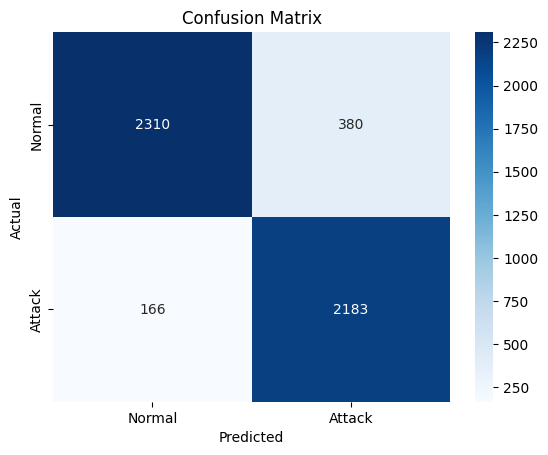

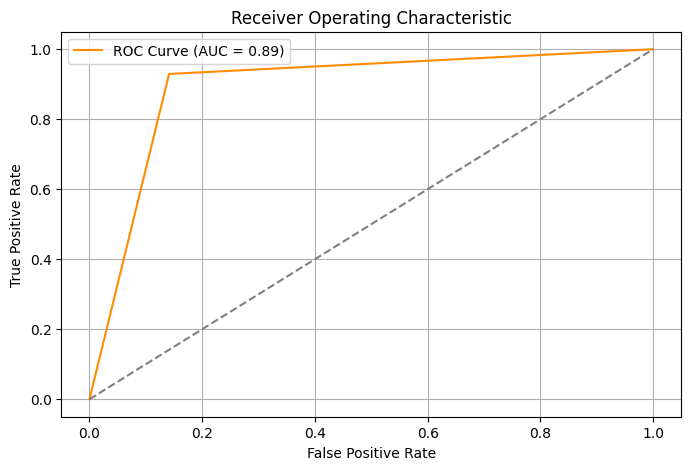

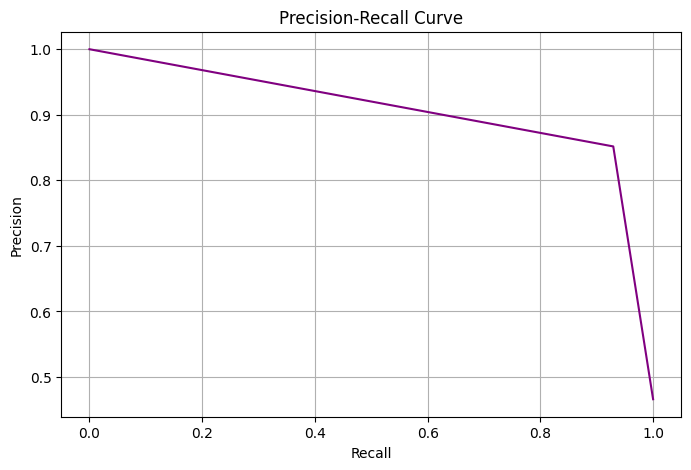


📊 Classification Report:

              precision    recall  f1-score   support

      Normal       0.93      0.86      0.89      2690
      Attack       0.85      0.93      0.89      2349

    accuracy                           0.89      5039
   macro avg       0.89      0.89      0.89      5039
weighted avg       0.90      0.89      0.89      5039



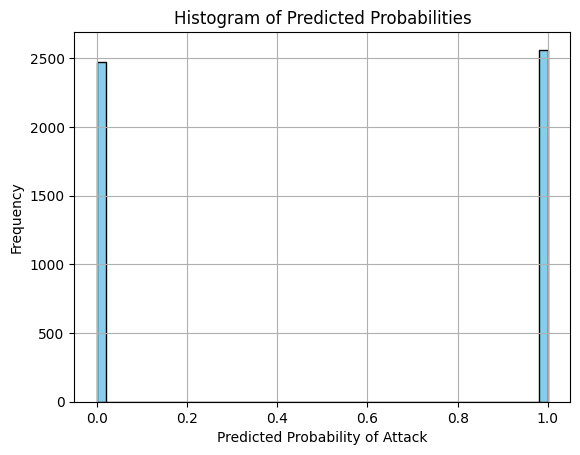

⚠️ Feature importance plot not available for custom models without coef_ attribute.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    RocCurveDisplay, ConfusionMatrixDisplay
)

# Load test set and pre-trained objects
X_test_scaled = joblib.load("scaler.pkl").transform(X_test)
poly = PolynomialFeatures(degree=1)
X_test_poly = poly.fit_transform(X_test_scaled)
model = joblib.load("classifier.pkl")

# Predictions
y_pred = model.predict(X_test_poly)
y_prob = model.predict_proba(X_test_poly)[:, 1] if hasattr(model, "predict_proba") else y_pred

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color="purple")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

# Histogram of predicted probabilities
plt.hist(y_prob, bins=50, color="skyblue", edgecolor="black")
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Probability of Attack")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Feature Importance (if weights accessible)
if hasattr(model, "coef_"):
    feature_names = poly.get_feature_names_out(X.columns)
    coefs = model.coef_.flatten()
    top_n = 15
    sorted_idx = np.argsort(np.abs(coefs))[-top_n:]
    plt.figure(figsize=(8, 5))
    plt.barh(range(top_n), coefs[sorted_idx], align='center', color="teal")
    plt.yticks(range(top_n), np.array(feature_names)[sorted_idx])
    plt.xlabel("Coefficient Value")
    plt.title("Top 15 Feature Importances (Logistic Regression)")
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Feature importance plot not available for custom models without coef_ attribute.")


In [1]:
!pip install scapy
import csv
import os
import time
import socket
from scapy.all import sniff, IP, TCP, UDP
from collections import defaultdict, deque

# ======= File setup =======
csv_file_path = "real_time_nids_features.csv"
csv_header = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]

# Always overwrite CSV file at start
with open(csv_file_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)

# ======= Flow tracking setup =======
flows = defaultdict(lambda: {
    'start_time': None,
    'end_time': None,
    'src_bytes': 0,
    'dst_bytes': 0,
    'count': 0,
    'services': set(),
    'dst_hosts': set(),
    'ports': set(),
    'tcp_flags': [],
    'logged_in': 0,
})
window = deque(maxlen=1000)
window_duration = 2  # seconds

# ======= Valid values from training data =======
valid_protocols = {'tcp', 'udp', 'icmp'}
valid_services = {
    'ftp_data', 'other', 'private', 'http', 'remote_job', 'name', 'netbios_ns', 'eco_i',
    'mtp', 'telnet', 'finger', 'domain_u', 'supdup', 'uucp_path', 'Z39_50', 'smtp',
    'csnet_ns', 'uucp', 'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
    'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois', 'imap4',
    'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login', 'kshell', 'sql_net',
    'time', 'hostnames', 'exec', 'ntp_u', 'discard', 'nntp', 'courier', 'ctf', 'ssh',
    'daytime', 'shell', 'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
    'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i', 'http_8001'
}
valid_flags = {'SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3', 'S2', 'OTH'}

def map_port_to_service(port):
    common_ports = {
        20: 'ftp_data', 21: 'ftp', 22: 'ssh', 23: 'telnet', 25: 'smtp', 53: 'domain',
        69: 'tftp_u', 80: 'http', 110: 'pop_3', 111: 'sunrpc', 119: 'nntp', 123: 'ntp_u',
        135: 'epmap', 137: 'netbios_ns', 138: 'netbios_dgm', 139: 'netbios_ssn',
        143: 'imap4', 161: 'snmp', 162: 'snmptrap', 179: 'bgp', 443: 'https',
        445: 'microsoft_ds', 513: 'login', 514: 'shell', 515: 'printer', 520: 'route',
        540: 'uucp', 635: 'mountd', 8080: 'http',
    }
    return common_ports.get(port, 'private' if port >= 1024 else 'other')

def map_flags_to_dataset(flag):
    if flag in ['PA', 'A', 'P', 'FA', 'F']:
        return 'SF'
    elif flag == 'S':
        return 'S0'
    elif flag in ['R', 'RA']:
        return 'REJ'
    return 'OTH'

def extract_features(pkt):
    try:
        if IP not in pkt:
            return
        ip = pkt[IP]
        proto = ip.proto
        now = time.time()

        if TCP in pkt or UDP in pkt:
            sport = pkt.sport
            dport = pkt.dport
        else:
            sport = dport = 0

        key = (ip.src, ip.dst, sport, dport, proto)
        flow = flows[key]

        if flow['start_time'] is None:
            flow['start_time'] = now
        flow['end_time'] = now
        flow['count'] += 1
        size = len(pkt)

        if ip.src == key[0]:
            flow['src_bytes'] += size
        else:
            flow['dst_bytes'] += size

        service_name = map_port_to_service(dport)
        flow['services'].add(service_name)
        flow['dst_hosts'].add(ip.dst)
        flow['ports'].add(dport)

        if TCP in pkt:
            tcp = pkt[TCP]
            flow['tcp_flags'].append(tcp.flags)
            if tcp.flags == "S":
                flow['logged_in'] = 0
            if tcp.flags == "PA":
                flow['logged_in'] = 1

        window.append({
            'src': ip.src, 'dst': ip.dst, 'proto': proto,
            'service': service_name, 'timestamp': now
        })

        duration = flow['end_time'] - flow['start_time']
        protocol_type = {6: 'tcp', 17: 'udp', 1: 'icmp'}.get(proto, 'other')
        service = list(flow['services'])[0] if flow['services'] else 'other'
        raw_flag = flow['tcp_flags'][-1] if flow['tcp_flags'] else '0'
        flag = map_flags_to_dataset(str(raw_flag))
        src_bytes = flow['src_bytes']
        dst_bytes = flow['dst_bytes']
        land = 1 if ip.src == ip.dst and sport == dport else 0

        # Skip if unknown values
        if protocol_type not in valid_protocols or service not in valid_services or flag not in valid_flags:
            print(f"[!] Skipping unknown values: {protocol_type}, {service}, {flag}")
            return

        # Static features
        wrong_fragment = urgent = hot = num_failed_logins = num_compromised = root_shell = su_attempted = 0
        num_root = num_file_creations = num_shells = num_access_files = num_outbound_cmds = 0
        is_host_login = is_guest_login = 0
        logged_in = flow['logged_in']

        recent = [w for w in window if now - w['timestamp'] <= window_duration]
        count = len([w for w in recent if w['dst'] == ip.dst])
        srv_count = len([w for w in recent if w['dst'] == ip.dst and w['service'] == service])
        same_srv_rate = srv_count / count if count else 0
        diff_srv_rate = 1 - same_srv_rate

        # Host-related metrics as placeholders
        serror_rate = srv_serror_rate = rerror_rate = srv_rerror_rate = srv_diff_host_rate = 0
        dst_host_count = count
        dst_host_srv_count = srv_count
        dst_host_same_srv_rate = same_srv_rate
        dst_host_diff_srv_rate = diff_srv_rate
        dst_host_same_src_port_rate = dst_host_srv_diff_host_rate = 0
        dst_host_serror_rate = dst_host_srv_serror_rate = dst_host_rerror_rate = dst_host_srv_rerror_rate = 0

        features = [
            duration, protocol_type, service, flag, src_bytes, dst_bytes, land,
            wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised,
            root_shell, su_attempted, num_root, num_file_creations, num_shells,
            num_access_files, num_outbound_cmds, is_host_login, is_guest_login,
            count, srv_count, serror_rate, srv_serror_rate, rerror_rate,
            srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate,
            dst_host_count, dst_host_srv_count, dst_host_same_srv_rate,
            dst_host_diff_srv_rate, dst_host_same_src_port_rate,
            dst_host_srv_diff_host_rate, dst_host_serror_rate,
            dst_host_srv_serror_rate, dst_host_rerror_rate,
            dst_host_srv_rerror_rate
        ]

        with open(csv_file_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(features)

        print("Captured:", features[:5], "...")

    except Exception as e:
        print(f"[!] Skipping packet due to error: {e}")

def start_sniffing(iface="eth0"):
    print("[*] Sniffing on:", iface)
    sniff(iface=iface, prn=extract_features, store=0)

if __name__ == "__main__":
    start_sniffing("eth0")  # Change to your interface, e.g., "wlan0"


[*] Sniffing on: eth0
Captured: [0.0, 'tcp', 'private', 'SF', 839] ...
Captured: [0.0, 'tcp', 'http', 'SF', 66] ...
Captured: [0.0, 'tcp', 'private', 'SF', 800] ...
Captured: [0.0, 'tcp', 'http', 'SF', 66] ...
Captured: [0.20551419258117676, 'tcp', 'private', 'SF', 1577] ...
Captured: [0.20561933517456055, 'tcp', 'http', 'SF', 132] ...
Captured: [0.0, 'tcp', 'http', 'S0', 74] ...
Captured: [0.0, 'tcp', 'private', 'OTH', 74] ...
Captured: [0.004448890686035156, 'tcp', 'http', 'SF', 140] ...
Captured: [0.005449056625366211, 'tcp', 'http', 'SF', 1003] ...
Captured: [0.0028831958770751953, 'tcp', 'private', 'SF', 140] ...
Captured: [0.0038437843322753906, 'tcp', 'private', 'SF', 768] ...
Captured: [0.008182048797607422, 'tcp', 'http', 'SF', 1069] ...
Captured: [0.00900411605834961, 'tcp', 'http', 'SF', 1135] ...
Captured: [0.0064373016357421875, 'tcp', 'private', 'SF', 834] ...
Captured: [0.010729312896728516, 'tcp', 'http', 'SF', 1201] ...
Captured: [0.41135120391845703, 'tcp', 'private',

In [7]:
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Handle unseen labels manually
def safe_label_transform(le, col_values):
    known_classes = set(le.classes_)
    unknowns = set(col_values.unique()) - known_classes
    if unknowns:
        print(f"[Warning] Unknown categories detected: {unknowns}")
        # Replace unknowns with a placeholder or drop the rows
        col_values = col_values.apply(lambda x: x if x in known_classes else "unknown")
        # Add the 'unknown' label to encoder if it's not there
        if "unknown" not in le.classes_:
            le.classes_ = np.append(le.classes_, "unknown")
    return le.transform(col_values)

def classify_network_traffic(csv_path):
    le_protocol = joblib.load("le_protocol.pkl")
    le_service = joblib.load("le_service.pkl")
    le_flag = joblib.load("le_flag.pkl")
    scaler = joblib.load("scaler.pkl")
    clf = joblib.load("classifier.pkl")

    df = pd.read_csv(csv_path)
    # Encode categorical columns
    df["protocol_type"] = safe_label_transform(le_protocol, df["protocol_type"])
    df["service"] = safe_label_transform(le_service, df["service"])
    df["flag"] = safe_label_transform(le_flag, df["flag"])


    # Select features
    feature_cols = [
        "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
        "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
        "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
        "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
        "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
        "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
        "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
    ]

    # Prepare input and scale
    X = df[feature_cols]
    X_scaled = scaler.transform(X)
    poly = PolynomialFeatures(degree=1)
    X_trf = poly.fit_transform(X_scaled)
    # Predict
    predictions = clf.predict(X_trf)
    label_map = {0: "normal", 1: "attack"}
    mapped_preds = np.vectorize(label_map.get)(predictions)

    # Print unique labels with counts
    unique_labels, counts = np.unique(mapped_preds, return_counts=True)
    raw_dict = dict(zip(unique_labels, counts))
    clean_dict = {str(k): int(v) for k, v in raw_dict.items()}

    return clean_dict
print("Network Classification over Real Time Networks : ")
print(classify_network_traffic("/content/real_time_nids_features.csv"))
print("Network Classification over Test Data : ")
print(classify_network_traffic("/content/drive/MyDrive/Test_data.csv"))

Network Classification over Real Time Networks : 
{'attack': 1, 'normal': 59}
Network Classification over Test Data : 
[Warning] Unknown categories detected: {'tftp_u'}
{'attack': 9091, 'normal': 13453}
